In [52]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] = False
env = gym.make("Taxi-v3")
q_table = np.zeros([env.observation_space.n, env.action_space.n])
n_training_episodes = 25000
learning_rate = 0.1
gamma = 0.99
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.005
n_test_episodes = 100

def epsilon_greedy_policy(q_table, state, current_epsilon):
    if random.uniform(0, 1) > current_epsilon:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample()
    return action

def sarsa():
    q_table_algo = np.copy(q_table)
    rewards_per_episode = []
    current_epsilon = epsilon
    for episode in tqdm(range(n_training_episodes)):
        state, info = env.reset()
        done = False
        total_rewards = 0
        action = epsilon_greedy_policy(q_table_algo,state,epsilon)
        while not done:
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy_policy(q_table_algo, new_state, current_epsilon)
            old_value = q_table_algo[state, action]
            next_value = q_table_algo[new_state, next_action]
            new_value = old_value + learning_rate * (reward + gamma * next_value - old_value)
            q_table_algo[state, action] = new_value
            action = next_action
            state = new_state
            total_rewards += reward
        current_epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        rewards_per_episode.append(total_rewards)
    return q_table_algo,rewards_per_episode

def q_learning():
    q_table_algo = np.copy(q_table)
    rewards_per_episode = []
    current_epsilon = epsilon
    for episode in tqdm(range(n_training_episodes)):
        state, info = env.reset()
        done = False
        total_rewards = 0
        while not done:
            action = epsilon_greedy_policy(q_table_algo, state, current_epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            old_value = q_table_algo[state, action]
            next_max = np.max(q_table_algo[new_state])
            new_value = old_value + learning_rate * (reward + gamma * next_max - old_value)
            q_table_algo[state, action] = new_value
            state = new_state
            total_rewards += reward
        current_epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        rewards_per_episode.append(total_rewards)
    return q_table_algo,rewards_per_episode

def test(q_table_algo):
    total_epochs, total_penalties, total_rewards = 0, 0, 0
    for i in range(n_test_episodes):
        state, info = env.reset()
        epochs, penalties, reward_sum = 0, 0, 0
        done = False
        while not done:
            action = np.argmax(q_table_algo[state])
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if reward == -10:
                penalties += 1
            epochs += 1
            reward_sum += reward
        total_penalties += penalties
        total_epochs += epochs
        total_rewards += reward_sum

    print(f"测试结果 ({n_test_episodes} aepsiodes):")
    print(f"平均每个 episode 的步数: {total_epochs / n_test_episodes}")
    print(f"平均每个 episode 的惩罚次数: {total_penalties / n_test_episodes}")
    print(f"平均每个 episode 的总奖励: {total_rewards / n_test_episodes}")

    return {
        "avg_steps": total_epochs / n_test_episodes,
        "avg_penalties": total_penalties / n_test_episodes,
        "avg_reward": total_rewards / n_test_episodes
    }

print("训练Q-learning Agent")
q_learning_q_table, q_learning_rewards = q_learning()
print("\n测试 Q-learning Agent")
q_learning_results = test(q_learning_q_table)

print("\n训练Sarsa Agent")
sarsa_q_table, sarsa_rewards = sarsa()
print("\n测试Sarsa Agent")
sarsa_results = test(sarsa_q_table)

训练Q-learning Agent


100%|██████████| 25000/25000 [00:11<00:00, 2115.63it/s]



测试 Q-learning Agent
测试结果 (100 aepsiodes):
平均每个 episode 的步数: 12.89
平均每个 episode 的惩罚次数: 0.0
平均每个 episode 的总奖励: 8.11

训练Sarsa Agent


100%|██████████| 25000/25000 [00:09<00:00, 2557.82it/s]


测试Sarsa Agent
测试结果 (100 aepsiodes):
平均每个 episode 的步数: 12.89
平均每个 episode 的惩罚次数: 0.0
平均每个 episode 的总奖励: 8.11


感觉这个环境确实比较简单，第一次尝试使用衰减epsilon策略就能很好的收敛，所以我尝试在atari系列中的air raid中进行实验，训练一个agent

**解释online与offline的区别**
- online
    - 在上面的sarsa中体现
    - 只有一个策略，不断使用，评估然后改进
    - 遵循 行动 -> 评估 -> 改进 的循环。它一边探索，一边把探索本身带来的影响考虑进价值函数中
- offline
    - 在上面的q-learning中体现
    - 分为行为策略和目标策略，行为策略做决策，更新目标策略
    - 行为策略用于收集数据，而目标策略用于更新价值。

在sarsa中在更新Q值 时，用的是当前策略下实际选择的 next_action

在q-learning更新时不关心当前策略实际会选哪个动作，而是直接用 max(q_tabel(new_state))

**算法中的探索与利用**

ε-贪婪策略的作用

```python
def epsilon_greedy_policy(self, state, current_epsilon):
    if random.uniform(0, 1) > current_epsilon:
        action = np.argmax(self.q_table[state])  # 利用
    else:
        action = self.env.action_space.sample()  # 探索
```
- 探索：随机选择动作，发现新的可能更好的策略
- 利用：选择当前认为最好的动作，获得最大奖励
- ε衰减：随着训练进行，逐渐从探索转向利用

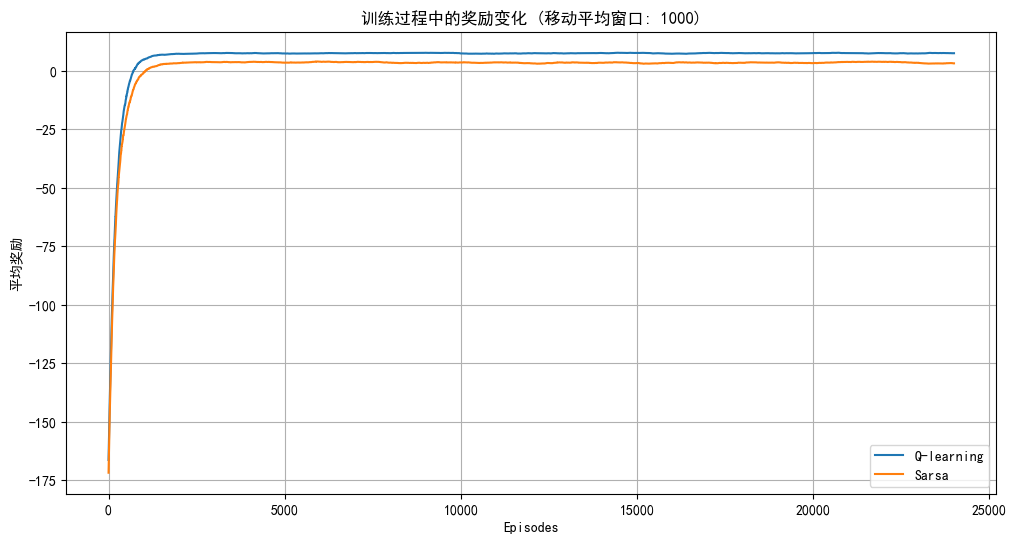

In [53]:
def plot_learning_curve(rewards_dict, window=1000):
    plt.figure(figsize=(12, 6))
    for label, rewards in rewards_dict.items():
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(moving_avg, label=label)
    plt.title(f'训练过程中的奖励变化 (移动平均窗口: {window})')
    plt.xlabel('Episodes')
    plt.ylabel('平均奖励')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_learning_curve({"Q-learning": q_learning_rewards, "Sarsa": sarsa_rewards})

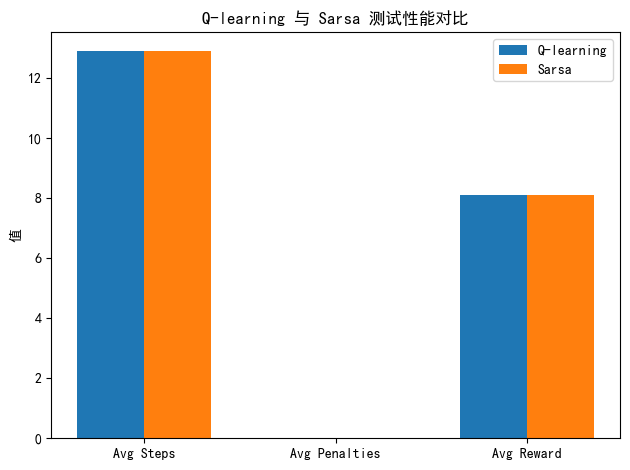

In [54]:
labels = ['Avg Steps', 'Avg Penalties', 'Avg Reward']
q_metrics = [q_learning_results[k] for k in ['avg_steps', 'avg_penalties', 'avg_reward']]
sarsa_metrics = [sarsa_results[k] for k in ['avg_steps', 'avg_penalties', 'avg_reward']]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, q_metrics, width, label='Q-learning')
rects2 = ax.bar(x + width/2, sarsa_metrics, width, label='Sarsa')
ax.set_ylabel('值')
ax.set_title('Q-learning 与 Sarsa 测试性能对比')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

尝试加入reward-shaping

使用曼哈顿距离来衡量，当有乘客在车上并靠近目的地时或者乘客不在车上靠近乘客时给予额外奖励

In [55]:
locs = [(0, 0), (0, 4), (4, 0), (4, 3)]
def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

In [69]:
def q_learning_with_reward_shaping():
    q_table_algo = np.copy(q_table)
    rewards_per_episode = []
    current_epsilon = epsilon
    for episode in tqdm(range(n_training_episodes), desc="Training with Reward Shaping"):
        state, info = env.reset()
        done = False
        total_rewards = 0
        while not done:
            action = epsilon_greedy_policy(q_table_algo, state, current_epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            shaped_reward = reward
            decoded_state = list(env.decode(state))
            decoded_new_state = list(env.decode(new_state))
            old_taxi_pos = (decoded_state[0], decoded_state[1])
            new_taxi_pos = (decoded_new_state[0], decoded_new_state[1])
            passenger_loc_idx = decoded_state[2]
            dest_loc_idx = decoded_state[3]
            if passenger_loc_idx == 4:
                target_pos = locs[dest_loc_idx]
                old_dist = manhattan_distance(old_taxi_pos, target_pos)
                new_dist = manhattan_distance(new_taxi_pos, target_pos)
                if new_dist < old_dist:
                    shaped_reward += 0.5
                elif new_dist > old_dist:
                    shaped_reward -= 0.5
            else:
                target_pos = locs[passenger_loc_idx]
                old_dist = manhattan_distance(old_taxi_pos, target_pos)
                new_dist = manhattan_distance(new_taxi_pos, target_pos)
                if new_dist < old_dist:
                    shaped_reward += 0.5
                elif new_dist > old_dist:
                    shaped_reward -= 0.5
            old_value = q_table_algo[state, action]
            next_max = np.max(q_table_algo[new_state])
            new_value = old_value + learning_rate * (shaped_reward + gamma * next_max - old_value)
            q_table_algo[state, action] = new_value
            state = new_state
            total_rewards += reward
        current_epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        rewards_per_episode.append(total_rewards)

    return q_table_algo, rewards_per_episode


训练有Reward Shaping的Q-learning Agent


Training with Reward Shaping: 100%|██████████| 25000/25000 [00:13<00:00, 1861.62it/s]



测试有Reward Shaping的Q-learning Agent
测试结果 (100 aepsiodes):
平均每个 episode 的步数: 13.06
平均每个 episode 的惩罚次数: 0.0
平均每个 episode 的总奖励: 7.94


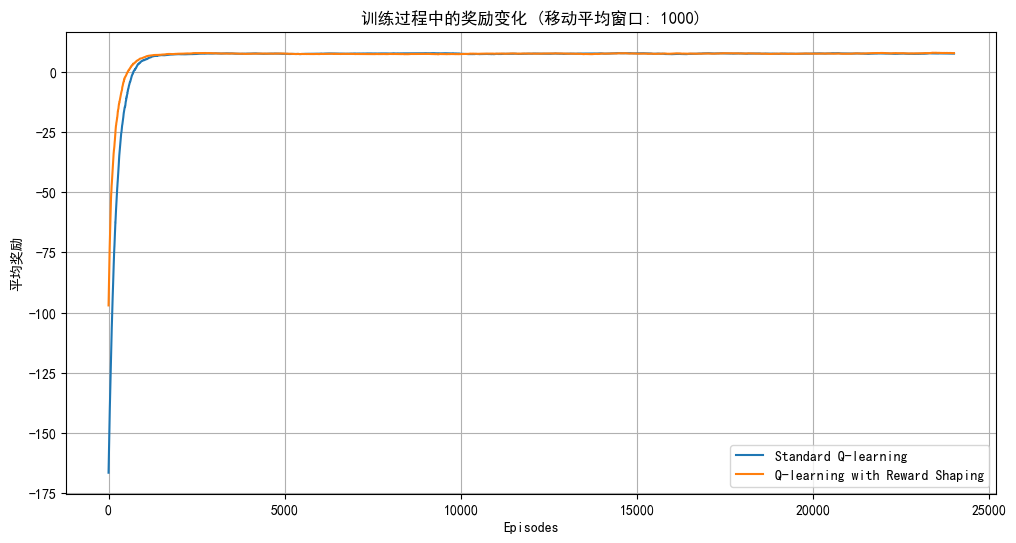

In [70]:
print("\n训练有Reward Shaping的Q-learning Agent")
rs_q_table, rs_rewards = q_learning_with_reward_shaping()
print("\n测试有Reward Shaping的Q-learning Agent")
rs_results = test(rs_q_table)
plot_learning_curve({
    "Standard Q-learning": q_learning_rewards,
    "Q-learning with Reward Shaping": rs_rewards
}, window=1000)

使用reward-shaping后发现增加的距离奖励机制当额外奖励给的大一点（如0.1，0.2，0.5，1递增）时，平均步数与奖励变化不大，但是收敛速度明显递增了